<a href="https://www.kaggle.com/code/sashafromlibertalia/anime-analysis?scriptVersionId=110443248" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import random

import numpy as np
import pandas as pd

from sklearn import linear_model
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from matplotlib import pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
anime = pd.read_csv('../input/anime-recommendations-database/anime.csv')
ratings = pd.read_csv('../input/anime-recommendations-database/rating.csv')

anime = anime.dropna()
anime = anime[anime["episodes"].str.contains("Unknown") == False]

In [3]:
data = pd.merge(ratings, anime, on='anime_id')
data = data.dropna()
data = data.drop('rating_y', axis=1)
data.rename(columns = {'rating_x':'rating'}, inplace = True)
data = data[data['rating'] != -1]
data

,user_id,anime_id,rating,name,genre,type,episodes,members
1,3,20,8,Naruto,"Action, Comedy, Martial Arts, Shounen, Super P...",TV,220,683297
2,5,20,6,Naruto,"Action, Comedy, Martial Arts, Shounen, Super P...",TV,220,683297
5,21,20,8,Naruto,"Action, Comedy, Martial Arts, Shounen, Super P...",TV,220,683297
6,28,20,9,Naruto,"Action, Comedy, Martial Arts, Shounen, Super P...",TV,220,683297
7,34,20,9,Naruto,"Action, Comedy, Martial Arts, Shounen, Super P...",TV,220,683297
...,...,...,...,...,...,...,...,...
7813600,65175,30095,7,Qi Cai Lao Fu Zi,"Action, Comedy, Seinen",Movie,1,82
7813601,65175,30096,7,Lao Fu Zi Shui Hu Chuan,"Comedy, Historical, Seinen",Movie,1,65
7813602,65682,30450,8,Dr. Slump: Hoyoyo! Arale no Himitsu Dai Koukai...,"Comedy, Sci-Fi, Shounen",Special,1,248
7813603,69497,33484,10,Shiroi Zou,"Action, Historical, Kids",Movie,1,45


## Анализ жанров

Чтобы определить, что смотрят нынче анимешники, сначала вытащим все жанры аниме

In [4]:
dirty_genre_list = list(set(data.genre))
genre_list = list(set([g for x in dirty_genre_list for g in x.split(', ')]))
pd.Series(genre_list)

0     Slice of Life
1        Historical
2             Space
3           Fantasy
4           Vampire
5          Military
6              Kids
7            Hentai
8              Game
9             Music
10          Mystery
11            Mecha
12           Seinen
13           Shoujo
14            Magic
15            Drama
16         Thriller
17           Sci-Fi
18           Police
19        Shoujo Ai
20       Shounen Ai
21           Sports
22           Demons
23      Super Power
24            Ecchi
25            Josei
26             Cars
27     Supernatural
28    Psychological
29             Yaoi
30           School
31          Samurai
32           Comedy
33            Harem
34        Adventure
35           Horror
36     Martial Arts
37             Yuri
38          Shounen
39           Parody
40          Romance
41         Dementia
42           Action
dtype: object

Теперь проанализируем, сколько фильмов в каждом жанре

In [5]:
stats_df = pd.DataFrame(columns=['Жанр', 'Число фильмов'])
stats_df['Жанр'] = genre_list
stats_df['Число фильмов'] = 0

for g in list(set(data.genre)):
    for genre in g.split(', '):
        stats_df.loc[stats_df['Жанр'] == genre, 'Число фильмов'] += 1
    
stats_df = stats_df.sort_values(by='Число фильмов', ascending=False)

In [6]:
stats_df

,Жанр,Число фильмов
32,Comedy,1221
42,Action,1134
17,Sci-Fi,803
15,Drama,795
34,Adventure,779
3,Fantasy,761
40,Romance,744
38,Shounen,636
27,Supernatural,567
30,School,453


<AxesSubplot:xlabel='Жанр'>

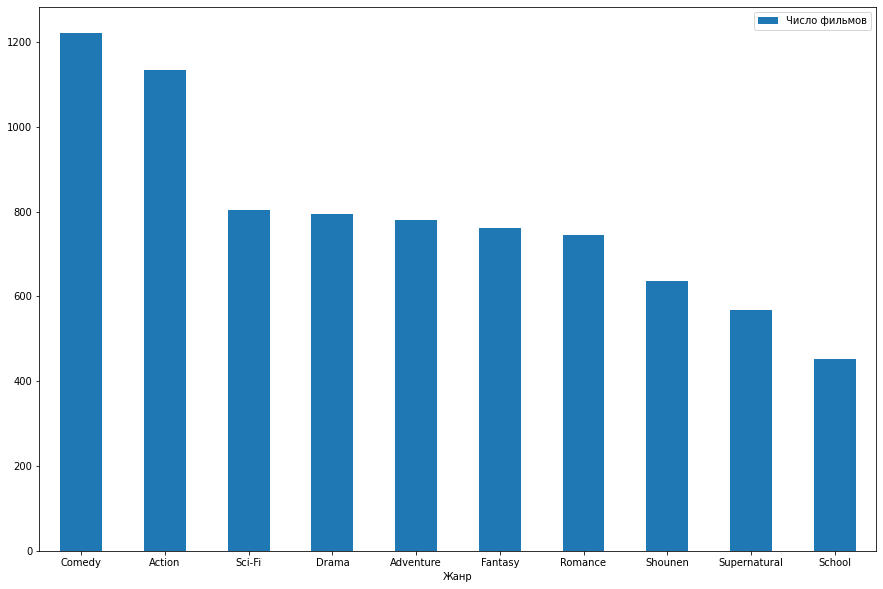

In [7]:
stats_df.set_index('Жанр').head(10).plot(kind='bar', figsize=(15, 10), rot=0)

## Выведение средней оценки аниме

Датасет предоставляет данные о отзывах людей о разных аниме, можно воспользоваться этим и найти среднее значение для каждого тайтла

In [8]:
mean_df = pd.DataFrame(columns=['Фильм', 'Средняя оценка'])
mean_df['Фильм'] = list(set(data['name']))
mean_df['Средняя оценка'] = list(data.groupby('name')['rating'].mean().round(2))
mean_df = mean_df.sort_values(by='Средняя оценка', ascending=False)
mean_df

,Фильм,Средняя оценка
7630,Mousou Dairinin,10.0
9397,Septem Charm Magical Kanan: SP Summer Camp,10.0
6840,Code Geass: Hangyaku no Lelouch Picture Drama,10.0
5489,Yarima Queen,10.0
4329,Personal Computer Travel Tanteidan,10.0
...,...,...
4662,Youjuu Kyoushitsu Gaiden,1.0
9704,Pop,1.0
6163,Hoshi no Kirby: Tokubetsu-hen - Taose!! Koukak...,1.0
149,Hunter x Hunter OVA,1.0


## Предсказание оценки на аниме

В датасете есть небольшое число признаков (`genre`, `type`, `episodes`, `members`), на основе которых можно попробовать предсказать отзыв человека. Введем целевую переменную

In [9]:
target_variable_name = 'rating'

Данные в датасете неотформатированны, в связи с чем модель будет выдавать ошибку. Исправим это

In [10]:
anime_df = anime.copy()
anime_df['genre'] = anime_df['genre'].agg(lambda x: x.split(', '))

In [11]:
type_data = list(set(anime_df['type'].values))
labelencoder = LabelEncoder()
anime_df['type'] = labelencoder.fit_transform(anime_df['type'])

In [12]:
genre_columns = list(map(lambda x: 'genre_' + x, genre_list)) ## Создадим отдельный столбец для каждого жанра

for genre in genre_columns:
    anime_df[genre] = 0

for i, v in enumerate(anime_df['genre'].values):
    for genre in genre_list:
        if genre in v:
            anime_df.loc[anime_df['genre_' + genre], i] = 1 ## Укажем принадлежность к жанру в нужной ячейке

anime_df = anime_df.drop('genre', axis=1) ## Избавимся от лишнего столбца

Отделим тренировочные данные и значения

In [13]:
y = anime_df[target_variable_name]
X = anime_df.drop(target_variable_name, axis=1)[['type', 'episodes', 'members'] + genre_columns]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

In [14]:
X_train

,type,episodes,members,genre_Slice of Life,genre_Historical,genre_Space,genre_Fantasy,genre_Vampire,genre_Military,genre_Kids,...,genre_Harem,genre_Adventure,genre_Horror,genre_Martial Arts,genre_Yuri,genre_Shounen,genre_Parody,genre_Romance,genre_Dementia,genre_Action
11436,3,1,2563,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3460,3,2,3993,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9534,5,26,160,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7865,4,1,2889,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8507,1,1,40,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11734,3,2,1489,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5219,4,3,2371,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5420,3,2,21805,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
863,0,1,58184,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Обучим модель

In [15]:
model = linear_model.LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

Получим набор предсказаний

In [16]:
y_pred = model.predict(X_test)
y_pred

array([6.35463962, 6.09166648, 6.35448788, ..., 6.36470709, 6.36442517,
       6.63862111])

Также было бы неплохо узнать значение MAE и MSE:

In [17]:
print("MSE:", mean_squared_error(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))

MSE: 0.8675144277172485
MAE: 0.7191412804821699


Результаты не очень хорошие. Поскольку к исходному датасету были добавлены столбцы, отвечающие за отдельный жанр, получилась ситуация, в которой много признаков, имеющих нулевое значение. Есть подозрение, что этот факт сказывается на качестве предсказаний. Потенциальное решение - использовать больше **разных** признаков, а также оставить лишь 1 жанр для тайтла. Давайте узнаем, какой вес у каждого признака

### Анализ важности признаков

In [18]:
linear_weights = abs(model.coef_)

feature_importance = pd.DataFrame(columns = ['Название признака', 'Важность признака'])
feature_importance['Название признака'] = X_test.columns
feature_importance['Важность признака'] = linear_weights
feature_importance.sort_values(by='Важность признака', ascending=False)

,Название признака,Важность признака
0,type,0.104826
1,episodes,0.000353
2,members,0.000007
44,genre_Dementia,0.000000
25,genre_Demons,0.000000
26,genre_Super Power,0.000000
27,genre_Ecchi,0.000000
28,genre_Josei,0.000000
29,genre_Cars,0.000000
30,genre_Supernatural,0.000000


Я оказался прав

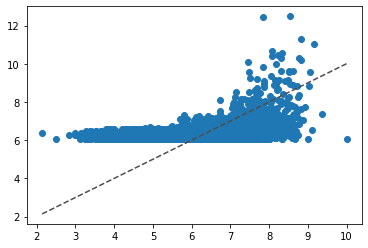

In [19]:
plt.scatter(y_test, y_pred)
plt.plot([min(y_test),max(y_test)], [min(y_test),max(y_test)], ls="--", c=".3")

## Задача классификации

Введем задачу классификации - начнем предсказывать, посмотрит ли человек какой-то тайтл или нет. Поскольку таких данных в датасете нету, я буду их генерить случайно.

Кроме того, мы заметили, что разбивать столбец с жанрами отдельно на все жанры - плохая идея, так как модель оказывается весьма неточной. Поэтому каждый тайтл будет иметь **только 1 жанр**.

Этапы решения данной задачи будут следующими:
1. Оставить только один жанр у аниме
2. Случайным образом распределить статистику просмотров
3. Решить задачу классификации

> В датасете очень много данных, для примера я возьму только 100000 строк

### Этап первый

In [20]:
anime_df = anime.copy()
anime_df['genre'] = anime_df['genre'].agg(lambda x: random.choice(x.split(', ')))

### Этап второй

In [21]:
data = pd.merge(ratings, anime_df, on='anime_id')
data = data.dropna()
data = data.drop('rating_x', axis=1)
data.rename(columns = {'rating_y':'rating'}, inplace = True)
data['watched'] = np.random.randint(2, size=data.shape[0])
data = data.sample(100000)
data

,user_id,anime_id,name,genre,type,episodes,rating,members,watched
1456103,37763,14345,Btooom!,Seinen,TV,12,7.68,329561,0
7039707,41370,2841,Kuro Ai: Hitoyozumakan Inkou Rannyuuroku,Hentai,OVA,2,6.84,6495,0
4046570,49474,759,Tokyo Godfathers,Comedy,Movie,1,8.32,89424,1
7228186,10948,1525,Pokemon Crystal: Raikou Ikazuchi no Densetsu,Kids,Special,1,7.04,13929,0
7029299,69835,830,Sexfriend,Hentai,OVA,2,6.79,9174,0
...,...,...,...,...,...,...,...,...,...
7622408,59528,722,Baby☆Love,Comedy,OVA,1,6.45,3708,1
4612514,41950,256,Hoshi no Koe,Romance,OVA,1,7.53,85492,1
737427,61995,14813,Yahari Ore no Seishun Love Comedy wa Machigatt...,School,TV,13,8.12,353876,0
5548823,1842,71,Full Metal Panic!,Comedy,TV,24,7.81,256325,0


### Этап третий

Отлично, теперь можно начать предсказывать. Для чистоты эксперимента избавимся от столбцов `user_id`, `anime_id` и `name`. Помимо этого, воспользуемся LabelEncoder, чтобы обучать нашу модель на численных данных

In [22]:
data = data.drop(['user_id', 'name', 'anime_id'], axis=1)

In [23]:
# genres_one_hot = pd.get_dummies(data['genre'] , prefix='genre') <-- One Hot Encoder
# data = data.drop('genre', axis = 1)
# data = data.join(genres_one_hot)
data['type'] = labelencoder.fit_transform(data['type']) ## Лучше везде использовать One Hot Encoder, но для эксперимента применим разные инструменты
data['genre'] = labelencoder.fit_transform(data['genre'])

> Я закомментировал One Hot Encoder не просто так . Экспериментальным путем было установлено, что большая часть жанров не несет никакого веса при решении задачи классификации, и итоговый accuracy_score практически не отличается от полученного ниже результата.

Наша целевая переменная - `watched`. Разделим наш датасет

In [24]:
target_variable = 'watched'

In [25]:
y = data[target_variable]
X = data.drop(target_variable, axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [26]:
tree = DecisionTreeClassifier(criterion = "entropy", max_depth = 5, min_samples_leaf = 5)
tree.fit(X_train, y_train)
y_pred = tree.predict(X_test)
print("Tree accuracy =", round(accuracy_score(y_test, y_pred), 3))

Tree accuracy = 0.5


<AxesSubplot:title={'center':'Важность признаков'}>

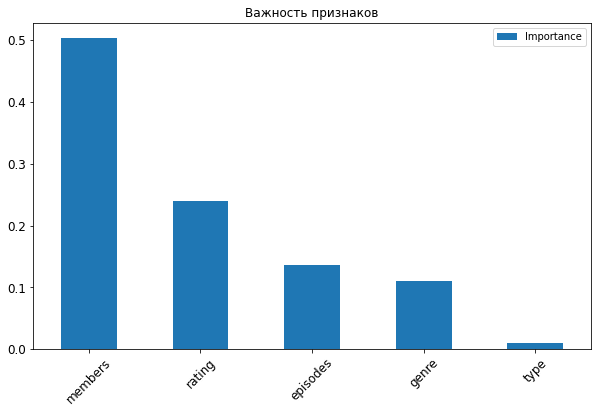

In [27]:
features = tree.feature_importances_
columns = list(X.columns)

stats = pd.DataFrame(data={'Feature': columns, 'Importance': features}, index=columns).sort_values(by='Importance', ascending=False)
stats.plot(kind='bar', title='Важность признаков', figsize=(10, 6), fontsize=12, rot=45)